IMPORTING LIBRARIES

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

GET DOCUMENTS AND LABELS FROM DATA ARRAY

In [32]:
def format_data(data):
    m = data.shape[1]
    labels = data[1].reshape((1, m))
    docs = data[2].reshape((1, m))
    return docs, labels

CONSTRUCTING A CLASS TO REPRESENT NAIVE BAYE'S MODEL

In [43]:
class Naive_Bayes:
    '''
    Parameters:
        training_data, training_labels, training_docs, m, vocab, total_label_len, label_freq, phi, word_params
        vocab : word -> {pos_freq, neg_freq, neutral_freq}
    '''
    def __init__(self, training_data, label_selector, data_formatter):
        self.training_data = training_data
        self.formatter = data_formatter
        self.label_selection = {"MULTINOULLI": self.multinoulli_selector, "RANDOM": self.random_selector, "POSITIVE": self.always_positive}
        self.label_selector = self.label_selection[label_selector]
        self.vocab = {}
        self.total_label_len = {"Positive": 0, "Negative": 0, "Neutral": 0}
        self.label_freq = {"Positive": 0, "Negative": 0, "Neutral": 0}
        self.vocab_len = 0
        self.phi = {}
        self.word_params = {}
        self.training_docs, self.training_labels = data_formatter(self.training_data)
        self.m = self.training_docs.shape[1]
        self.create_vocabulary()
        self.estimate_parameters()

    def create_vocabulary(self):
        for i in range(self.m):
            label = self.training_labels[0][i]
            doc = self.training_docs[0][i]
            words = doc.split()

            self.label_freq[label] += 1
            self.total_label_len[label] += len(words)

            for word in words:
                if word not in self.vocab.keys():
                    self.vocab[word] = {"Positive": 0, "Negative": 0, "Neutral": 0}
                self.vocab[word][label] += 1
        self.vocab_len = len(self.vocab)

    def estimate_parameters(self):
        phi_pos = (self.label_freq["Positive"]) / (self.m)
        phi_neg = (self.label_freq["Negative"]) / (self.m)
        phi_neu = (self.label_freq["Neutral"]) / (self.m)

        self.phi = {"Positive": phi_pos, "Negative": phi_neg, "Neutral": phi_neu}

        for word in self.vocab:
            pos_freq = self.vocab[word]["Positive"]
            neg_freq = self.vocab[word]["Negative"]
            neu_freq = self.vocab[word]["Neutral"]

            pos_param = (pos_freq + 1) / (self.total_label_len["Positive"] + self.vocab_len)
            neg_param = (neg_freq + 1) / (self.total_label_len["Negative"] + self.vocab_len)
            neu_param = (neu_freq + 1) / (self.total_label_len["Neutral"] + self.vocab_len)

            self.word_params[word] = {"Positive": pos_param, "Negative": neg_param, "Neutral": neu_param}

    def compute_x_given_y(self, doc, label):
        log_prob = 0
        words = doc.split()

        for word in words:
            if word in self.vocab.keys():
                log_prob += np.log(self.word_params[word][label])

        return log_prob
    
    def multinoulli_selector(self, label):
        return np.log(self.phi[label])

    def random_selector(self, label):
        return np.log(1/3)
    
    def always_positive(self, label):
        return 0
    
    
    def get_inference(self, docs):
        inference = []

        for i in range(docs.shape[1]):
            doc = docs[0][i]

            pos_prob = self.compute_x_given_y(doc, "Positive") + self.label_selector("Positive")
            neg_prob = self.compute_x_given_y(doc, "Negative") + self.label_selector("Negative")
            neu_prob = self.compute_x_given_y(doc, "Neutral") + self.label_selector("Neutral")

            max_value = max(pos_prob, neg_prob, neu_prob)

            if max_value == pos_prob:
                inference.append("Positive")
            elif max_value == neg_prob:
                inference.append("Negative")
            else:
                inference.append("Neutral")
        
        return np.array(inference, ndmin=2)

In [45]:
training_data_1 = pd.read_csv('Corona_train.csv').to_numpy().T
model_1 = Naive_Bayes(training_data_1, "MULTINOULLI", format_data)
inference = model_1.get_inference(model_1.training_docs)

(np.sum(inference == model_1.training_labels))/(model_1.m)

0.8504648214663004

In [28]:
test_data = pd.read_csv('Corona_validation.csv').to_numpy().T

test_docs, test_labels = format_data(test_data)

inference = model_1.get_inference(test_docs)

(np.sum(inference == test_labels))/(test_docs.shape[1])

0.6705132098390525

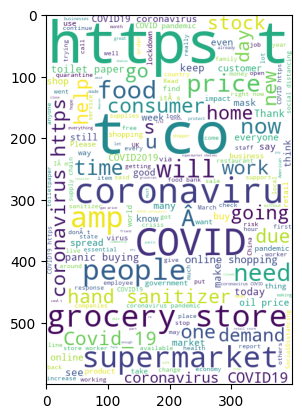

In [40]:
text = " ".join(model_1.training_docs.reshape(model_1.training_data.shape[1],))
stopwords = STOPWORDS
word_cloud = WordCloud(background_color='white', height=600, width=400, stopwords=stopwords)
word_cloud.generate(text)
plt.imshow(word_cloud.to_image())